## Get all imports

In [1]:
import math
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import time
from FRUFS import FRUFS
from sklearn.cluster import KMeans
from matplotlib.pyplot import figure
from sklearn.metrics.cluster import normalized_mutual_info_score
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

## Load data

In [2]:
# Load the data into a dataframe
df = pd.read_csv("../data/adult/adult.csv")

# Convert target to class labels
df["income"] = [0 if i=="<=50K" else 1 for i in df["income"].values]

# Remove all rows having missing values
for col in df.columns:
    df = df[df[col] != '?']

# Specify which features are categorical
categorical_features = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "gender", "native-country"]
# Pre-process the data
for i in categorical_features:
    le = LabelEncoder()
    df[i] = le.fit_transform(df[i].values)

# Let's check out the processed dataframe
display(df.head())

df_train, df_test = train_test_split(df, test_size=0.2, stratify=df["income"].values, random_state=27)

# Separate out the target variable
Y_train = df_train["income"].values
Y_test = df_test["income"].values

# Drop the target from the train and test dataframes
df_train = df_train.drop(["income"], axis=1)
df_test = df_test.drop(["income"], axis=1)

# Also, let's check out the data shape
print(df_train.shape, df_test.shape)

num_classes = 2

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,2,226802,1,7,4,6,3,2,1,0,0,40,38,0
1,38,2,89814,11,9,2,4,0,4,1,0,0,50,38,0
2,28,1,336951,7,12,2,10,0,4,1,0,0,40,38,1
3,44,2,160323,15,10,2,6,0,2,1,7688,0,40,38,1
5,34,2,198693,0,6,4,7,1,4,1,0,0,30,38,0


(36177, 14) (9045, 14)


## Modelling with Decision Tree without FRUFS (no feature selection)

In [3]:
model = DecisionTreeClassifier(random_state=27)
model.fit(df_train.values, Y_train)
preds = model.predict(df_test.values)

# We are going to use the F1-score metric to measure the quality/performance of the clustering 
score = f1_score(Y_test, preds)
print("Baseline F1 Score:", score)

Baseline F1 Score: 0.6216275499012942


## Modelling with FRUFS (feature selection is applied)

In [11]:
# Apply feature selection first
model_frufs = FRUFS(model_r=LGBMRegressor(random_state=27), model_c=LGBMClassifier(random_state=27, class_weight="balanced"), categorical_features=categorical_features, k=13, n_jobs=-1, verbose=0, random_state=27)
df_train_pruned = model_frufs.fit_transform(df_train)
df_test_pruned = model_frufs.transform(df_test)

# Now run decision tree on the pruned dataset
model = DecisionTreeClassifier(random_state=27)
model.fit(df_train_pruned.values, Y_train)
preds = model.predict(df_test_pruned.values)

score = f1_score(Y_test, preds)
print("F1 Score with feature selection:", score)

Progress bar: 100%|████████| 14/14 [00:11<00:00,  1.17it/s]


F1 Score with feature selection: 0.626500764025322


# Final Results (F1-score is used so higher is better)

### Final F1-score using all features: 62.16
### Final F1-score using FRUFS: 62.65

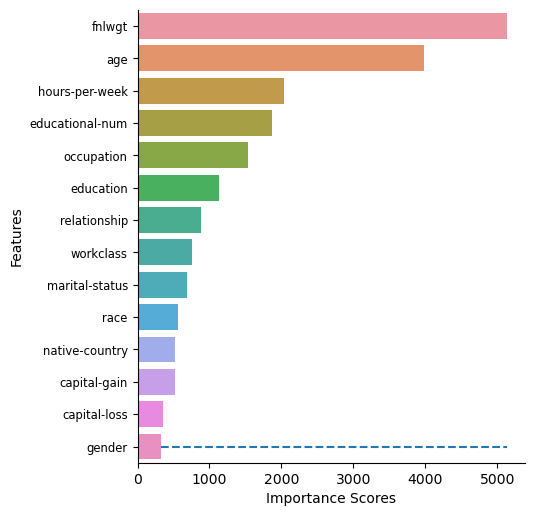

In [5]:
figure(figsize=(5, 6), dpi=100)
model_frufs.feature_importance()